In [1]:
import time
from typing import Optional, Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [12]:
torch.__version__

'1.13.1+cu117'

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [3]:
class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int,
              device_name: str) -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        for images, labels in loader:
            if device is not None:
                images = images.to(device)

            results = cnn(images)
            predictions = results.detach().cpu().numpy().argmax(axis=1)
            oks = (predictions == labels.numpy()).sum()
            correct += oks
            incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str) -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                cnn=model,
                epochs=20,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=2048,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

In [4]:
class Bias(nn.Module):
    def __init__(self, channels: int):
        super(Bias, self).__init__()
        self.channels = channels
        self.bias = nn.Parameter(torch.zeros(size=(1, channels, 1, 1)))

    def forward(self, x):
        assert x.size()[1] == self.channels, f"unknown size = {x.size()}, expected {self.channels}"
        return x + self.bias


class ComplexConv2d(nn.Module):
    """
    no bias!
    first half of channels is real part, second half - imaginary
    """

    def __init__(self, in_ch_complex: int, out_ch_complex: int, *, kernel_size: int):
        super(ComplexConv2d, self).__init__()
        self.in_ch_complex = in_ch_complex
        self.out_ch_complex = out_ch_complex

        self.conv_re = nn.Conv2d(in_ch_complex, out_ch_complex, bias=False, stride=1, kernel_size=kernel_size,
                                 padding='valid')
        self.conv_im = nn.Conv2d(in_ch_complex, out_ch_complex, bias=False, stride=1, kernel_size=kernel_size,
                                 padding='valid')

    def forward(self, x):
        assert x.size()[1] == self.in_ch_complex * 2
        re, im = x[:, :self.in_ch_complex], x[:, self.in_ch_complex:]

        out_re = self.conv_re(re) - self.conv_im(im)
        out_im = self.conv_im(re) + self.conv_re(im)

        return torch.cat([out_re, out_im], dim=1)


class Grouped2Conv2d(nn.Module):
    """
    no bias!
    channels are shuffled before convolutions
    """

    def __init__(self, in_ch_complex: int, out_ch_complex: int, *, kernel_size: int):
        super(Grouped2Conv2d, self).__init__()
        self.in_ch_complex = in_ch_complex
        self.out_ch_complex = out_ch_complex

        self.conv_a = nn.Conv2d(in_ch_complex, out_ch_complex, bias=False, stride=1, kernel_size=kernel_size,
                                padding='valid')
        self.conv_b = nn.Conv2d(in_ch_complex, out_ch_complex, bias=False, stride=1, kernel_size=kernel_size,
                                padding='valid')

    def forward(self, x):
        assert x.size()[1] == self.in_ch_complex * 2
        a, b = x[:, 0::2], x[:, 1::2]

        out_a = self.conv_a(a)
        out_b = self.conv_b(b)

        return torch.cat([out_a, out_b], dim=1)


class ComplexSquareMag(nn.Module):
    def __init__(self):
        super(ComplexSquareMag, self).__init__()

    def forward(self, x):
        channels = x.size()[1]
        assert channels % 2 == 0
        channels_half = channels // 2
        re, im = x[:, :channels_half], x[:, channels_half:]
        return re * re + im * im

In [5]:
class MyConvModel(nn.Module):
    def __init__(self, channels: int, mode: str):
        super(MyConvModel, self).__init__()
        self.channels = channels
        self.mode = mode

        c = channels
        self.conv1 = self.conv(1, c, kernel_size=3)  # 28 - 26
        self.conv2 = self.conv(c, c, kernel_size=3, max_pool=2)  # 26 - 24 - 12
        self.conv3 = self.conv(c, c * 2, kernel_size=3)  # 12 - 10
        self.conv4 = self.conv(c * 2, c * 2, kernel_size=3, max_pool=2)  # 10 - 8 - 4
        self.conv5 = self.conv(c * 2, c * 4, kernel_size=3)  # 4 - 2
        self.conv6 = self.conv(c * 4, c * 4, kernel_size=2)  # 2 - 1
        self.conv7 = self.conv(c * 4, 10, kernel_size=1, use_activation=False)
        self.squareMag = ComplexSquareMag()
        self.flatten = nn.Flatten()

    def conv(self, in_ch: int, out_ch: int, *, kernel_size, max_pool: int = 1, use_activation: bool = True):
        layers: List[nn.Module] = []

        if self.mode == 'complex':
            layers.append(ComplexConv2d(in_ch, out_ch, kernel_size=kernel_size))
        elif self.mode == 'grouped':
            layers.append(Grouped2Conv2d(in_ch, out_ch, kernel_size=kernel_size))
        elif self.mode == 'naive':
            layers.append(nn.Conv2d(in_ch * 2, out_ch * 2, kernel_size=kernel_size, padding='valid', bias=False))
        else:
            raise NameError(f"wrong mode: {self.mode}")

        if max_pool != 1:
            layers.append(nn.MaxPool2d(kernel_size=max_pool))

        layers.append(Bias(out_ch * 2))

        if use_activation:
            layers.append(nn.LeakyReLU(0.1))

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        x = torch.cat([x, x * 0.0], dim=1)  # convert to complex
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.squareMag(x)
        x = self.flatten(x)
        return x

In [6]:
modes = ['naive', 'complex', 'grouped']
channel_multipliers = [4, 6, 8, 12, 16, 24, 32, 48, 64]
results = {mode: [] for mode in modes}

## Cell below could be executed several times to get more points

In [9]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'

for i in range(4):
    for mode in modes:
        models = [MyConvModel(n, mode=mode) for n in channel_multipliers]
        for pair in TrainHelper.train_models(models, device_name=device_name):
            results[mode].append(pair)

best accuracy = 0.9789, parameters = 13652, training time = 82.76076912879944
best accuracy = 0.9873, parameters = 30020, training time = 82.13722538948059
best accuracy = 0.9877, parameters = 52756, training time = 82.67326068878174
best accuracy = 0.9905, parameters = 117332, training time = 81.3103928565979
best accuracy = 0.992, parameters = 207380, training time = 82.03486013412476
best accuracy = 0.9926, parameters = 463892, training time = 83.0224015712738
best accuracy = 0.9933, parameters = 822292, training time = 83.42394495010376
best accuracy = 0.9936, parameters = 1844756, training time = 134.27495765686035
best accuracy = 0.9941, parameters = 3274772, training time = 191.3337700366974
best accuracy = 0.98, parameters = 6892, training time = 83.84906268119812
best accuracy = 0.983, parameters = 15104, training time = 83.69074177742004
best accuracy = 0.9869, parameters = 26500, training time = 84.17240023612976
best accuracy = 0.9909, parameters = 58844, training time = 85

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


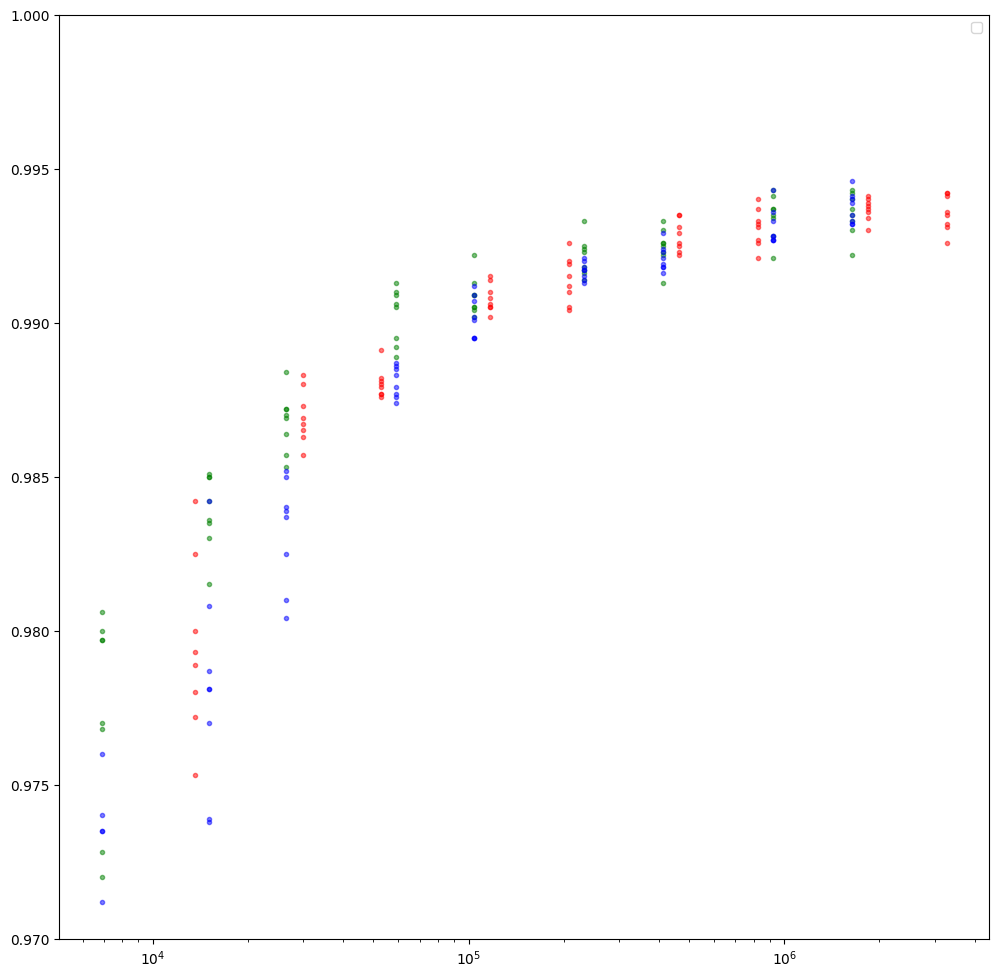

In [10]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.97, 1)

mode_to_color = {
    'naive': 'red',
    'complex': 'green',
    'grouped': 'blue',
}

for mode in modes:
    list_of_pairs = results[mode]
    params_counts = [p[0] for p in list_of_pairs]
    accuracies = [p[1] for p in list_of_pairs]

    ax.scatter(params_counts, accuracies, c=mode_to_color[mode], alpha=0.5, marker=r'.')

ax.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


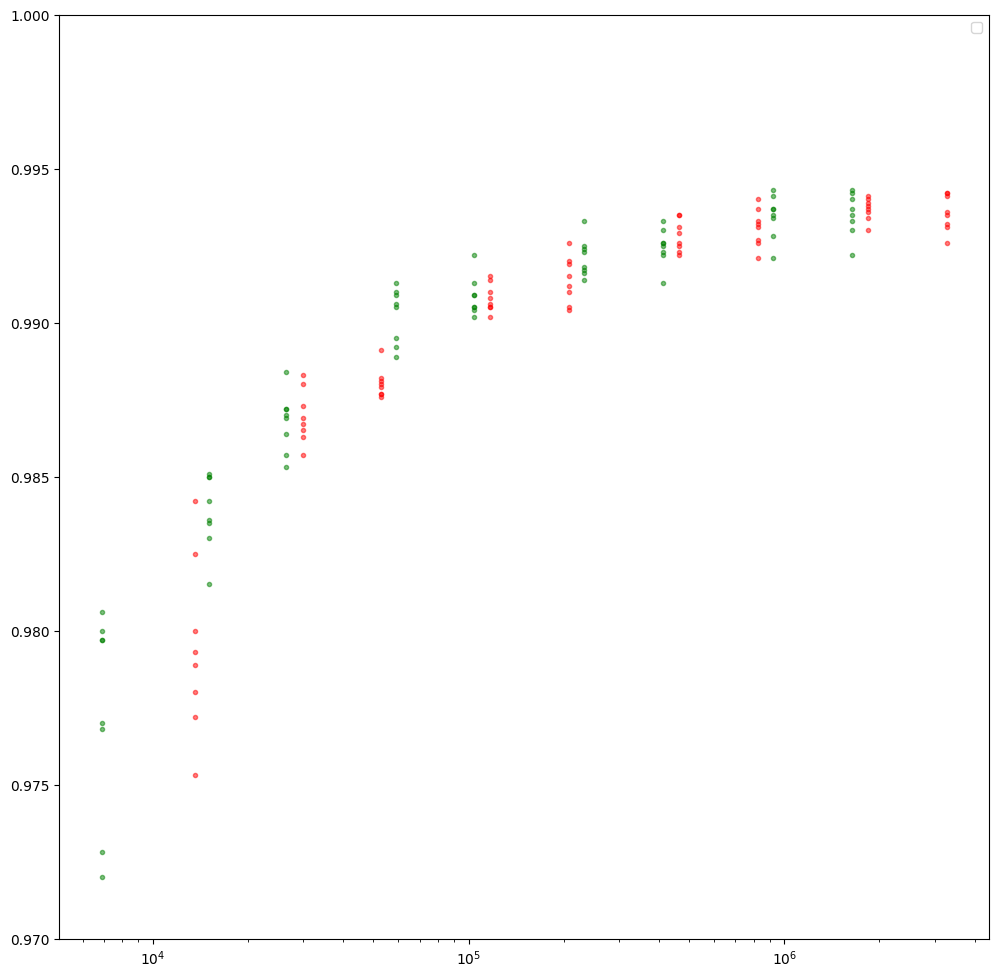

In [11]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.97, 1)

mode_to_color = {
    'naive': 'red',
    'complex': 'green',
    'grouped': 'blue',
}

for mode in ['naive', 'complex']:
    list_of_pairs = results[mode]
    params_counts = [p[0] for p in list_of_pairs]
    accuracies = [p[1] for p in list_of_pairs]

    ax.scatter(params_counts, accuracies, c=mode_to_color[mode], alpha=0.5, marker=r'.')

ax.legend()
plt.show()